In [ ]:
import os 
os.environ['TF_KERAS'] = '1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input,Activation,ZeroPadding2D,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, adam
from keras.models import model_from_json
from sklearn.metrics import confusion_matrix
from keras.models import load_model
# from keras import optimizers

In [ ]:
from keras.initializers import glorot_uniform
from keras.utils import plot_model
import scipy.misc
from matplotlib.pyplot import imshow

In [ ]:
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization


In [ ]:
def getZipFromDrive(fileId):
    # Install the PyDrive wrapper & import libraries.
    # This only needs to be done once per notebook.
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from io import BytesIO
    import zipfile
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    # Authenticate and create the PyDrive client.
    # This only needs to be done once per notebook.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    # Download a file based on its file ID.
    #
    # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
    # Music " 1p90klezsnQnleQdAZMgkGAf0ZHWepE3s "
    #https://drive.google.com/open?id=1frfTp6gQ10OWnLDvjT6pN-YTH56yelZy
    print("Downloading...")
    downloaded = drive.CreateFile({'id': fileId})
    
    toUnzipStringContent = downloaded.GetContentString(encoding='cp862')
    toUnzipBytesContent = BytesIO(toUnzipStringContent.encode('cp862'))
    readZipfile = zipfile.ZipFile(toUnzipBytesContent, "r")
    readZipfile.extractall()
  
getZipFromDrive("1frfTp6gQ10OWnLDvjT6pN-YTH56yelZy")

Downloading...


In [ ]:
source="/content/train/"
test_source="/content/test/"

In [ ]:
def getTrainFiles(classIndex):
    trainDir=source+"c"+str(classIndex)
    files=[os.path.join(trainDir, f) for f in os.listdir(trainDir)]
    return files

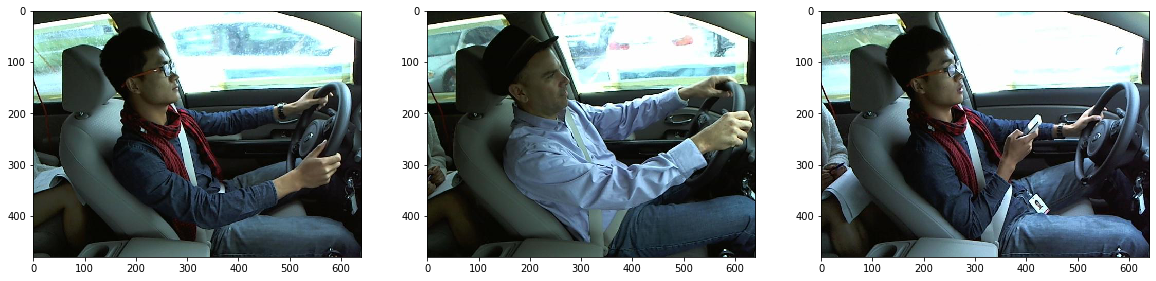

/content/train/c0/img_77696.jpg
/content/train/c0/img_25378.jpg
/content/train/c1/img_49336.jpg


In [ ]:
c0Files= getTrainFiles(0)
c1Files=getTrainFiles(1)

# img=mpimg.imread(c0Files[0])
# imgplot = plt.imshow(img)
# img.shape
# plt.show()
c01=mpimg.imread(c0Files[0])
c02=mpimg.imread(c0Files[1])
c11=mpimg.imread(c1Files[0])
fig,axes=plt.subplots(1,3,figsize=(20, 20))
axes[0].imshow(c01)
axes[1].imshow(c02)
axes[2].imshow(c11)
plt.show()
print(c0Files[0])
print(c0Files[1])
print(c1Files[0])

In [ ]:
# Create a class to store global variables. Easier for adjustments.
class Configuration:
    def __init__(self):
        self.epochs = 30
        self.batch_size = 50
        self.maxwidth =0
        self.maxheight=0
        self.minwidth = 35000
        self.minheight = 35000
        self.imgcount=0
        self.img_width_adjust = 480
        self.img_height_adjust= 360
        self.data_dir = source
        self.test_dir = test_source
config = Configuration()

In [ ]:
#Count the number of files in each subdirectory
def listDirectoryCounts(path):
    d = []
    for subdir, dirs_in_subdir, files in os.walk(path,topdown=False):
        filecount = len(files)
        dirname = subdir
        d.append((dirname,filecount))
    return d 

def SplitCat(df):
    for index, row in df.iterrows():
        directory=row['Category'].split('\\')
        if directory[-1]!='':
            directory=directory[-1]
            df.at[index,'Category']=directory
        else:
            df.drop(index, inplace=True)
    return
#Get image count per category
dirCount=listDirectoryCounts(config.data_dir)
categoryInfo = pd.DataFrame(dirCount, columns=['Category','Count'])
SplitCat(categoryInfo)
categoryInfo=categoryInfo.sort_values(by=['Category'])
print(categoryInfo.to_string(index=False))

          Category  Count
   /content/train/      0
 /content/train/c0   2489
 /content/train/c1   2267
 /content/train/c2   2317
 /content/train/c3   2346
 /content/train/c4   2326
 /content/train/c5   2312
 /content/train/c6   2325
 /content/train/c7   2002
 /content/train/c8   1911
 /content/train/c9   2129


In [ ]:
#Find the largest and smallest dimensions of all the pictures
def findPictureDims(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                config.imgcount+=1
                filename = os.path.join(subdir, file)
                image = Image.open(filename)
                width, height = image.size
                if width < config.minwidth:
                    config.minwidth = width
                if height < config.minheight:
                    config.minheight = height
                if width > config.maxwidth:
                    config.maxwidth = width
                if height > config.maxheight:
                    config.maxheight = height
    return
findPictureDims(config.data_dir)
print("Minimum Width:\t",config.minwidth, "\tMinimum Height:",config.minheight)
print("Maximum Width:\t",config.maxwidth, "\tMaximum Height:",config.maxheight, "\tImage Count:\t",config.imgcount)

Minimum Width:	 640 	Minimum Height: 480
Maximum Width:	 640 	Maximum Height: 480 	Image Count:	 22424


In [ ]:
from keras.optimizers import adam

In [ ]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (224,224,3), classes = 10):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (224,224,3), classes = 10)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# # # summarize the model
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:

#  # Compile the model
# sgd = SGD(lr=0.0009, decay=0.00001, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])

In [ ]:
#Setup data, and create split for training, testing 80/20
def setup_data(train_data_dir, val_data_dir, img_width=config.img_width_adjust, img_height=config.img_height_adjust, batch_size=config.batch_size):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,                           
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle=True,  
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        shuffle=True,  
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
        #Note uses training dataflow generator
    return train_generator, validation_generator

In [ ]:
def fit_model(model, train_generator, val_generator, batch_size, epochs):
    model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        verbose=1)
    return model



In [ ]:
#Setup data, and create split for training, testing 80/20
def setup1_data(test_dir, img_width=config.img_width_adjust, img_height=config.img_height_adjust, batch_size=config.batch_size):
    
    test_datagen = ImageDataGenerator(rescale=1./255) # set validation split
    

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        shuffle=True,  
        batch_size=batch_size,
        class_mode='categorical')
    return test_generator

In [ ]:
def eval_model(model, val_generator, batch_size):
    scores = model.evaluate_generator(val_generator, steps=val_generator.samples // batch_size)
    print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))


In [ ]:
# Create Data 80/20
train_generator, val_generator = setup_data(config.data_dir, config.data_dir, batch_size=config.batch_size,img_width=224, img_height=224)
test_generator = setup1_data (config.test_dir, batch_size=config.batch_size,img_width=224, img_height=224)

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [ ]:
train_generator.class_indices

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [ ]:
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import Adam
from keras.layers.pooling import GlobalAveragePooling2D

In [ ]:
# Build the model and show the summary data (note trainable parameters)
# input_shape = 299, 299, 3
# n_classes = 10
# model = googleNetV3(n_classes)
# print (model.summary())

In [ ]:
# Fit the model (If not already present)
# exists = os.path.isfile('dd_model.h5')
# if exists:
#     model = load_model('dd_model.h5')
# else:
#     history = fit_model(model, train_generator, val_generator,
#                   batch_size=config.batch_size,
                  # epochs=config.epochs, )

In [ ]:
batch_size=config.batch_size,
epoch=config.epochs

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size[0],
        epochs=40,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size[0],
        verbose=1)
# # history = fit_model( model, 
#         train_generator,
#         val_generator,
#         batch_size=config.batch_size,
#         # steps_per_epoch=train_generator.samples // batch_size[0],
      
#         epochs=40,
#        
#         # validation_steps=val_generator.samples // batch_size[0],
#         ) = fit_model( model, 
#         train_generator,
#         val_generator,
#         batch_size=config.batch_size,
#         # steps_per_epoch=train_generator.samples // batch_size[0],
      
#         epochs=40,
#         # validation_steps=val_generator.samples // batch_size[0],
#         )

Epoch 1/40
358/358 [==============================] - 525s 1s/step - loss: 2.5607 - acc: 0.2173 - val_loss: 14.4520 - val_acc: 0.1034
Epoch 2/40
358/358 [==============================] - 537s 1s/step - loss: 2.2229 - acc: 0.3265 - val_loss: 5.7444 - val_acc: 0.1250
Epoch 3/40
358/358 [==============================] - 531s 1s/step - loss: 1.8279 - acc: 0.4671 - val_loss: 2.1676 - val_acc: 0.3787
Epoch 4/40
358/358 [==============================] - 530s 1s/step - loss: 1.5037 - acc: 0.5890 - val_loss: 2.7391 - val_acc: 0.2796
Epoch 5/40
358/358 [==============================] - 534s 1s/step - loss: 1.1311 - acc: 0.7161 - val_loss: 1.1529 - val_acc: 0.6376
Epoch 6/40
358/358 [==============================] - 532s 1s/step - loss: 0.8592 - acc: 0.8007 - val_loss: 0.7200 - val_acc: 0.8012
Epoch 7/40
358/358 [==============================] - 529s 1s/step - loss: 0.7000 - acc: 0.8542 - val_loss: 1.1272 - val_acc: 0.7190
Epoch 8/40
358/358 [==============================] - 530s 1s/step -

In [ ]:
# from keras.callbacks import History 
# history = History()
print(history.history.keys())
# print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


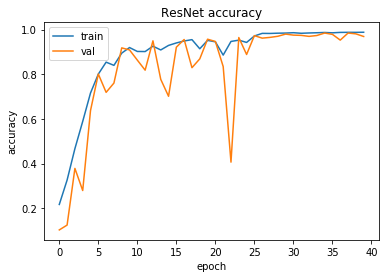

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ResNet accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

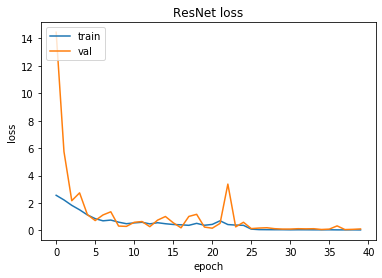

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate your model.
eval_model(model, val_generator, batch_size=config.batch_size)

Loss: 0.1032655419745179 Accuracy: 0.9719101157081261


In [ ]:
def plot_confusion_matrix(prediction,actual, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,confText=True,
                          colorBar=True ):
    """
    This function prints and plots the confusion matrix.
    """
    cm = confusion_matrix(actual, prediction)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    if(colorBar):
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if confText:
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:

print("length: ",len(val_generator))
# predict = model.predict_generator(val_generator,steps=len(val_generator))
index=0
# for val in predict:
#     print(val)
#     print(val.argmax(axis=-1))
#     print("index ",index)
#     index +=1
preds=[]
actual=[]
for var in range(len(val_generator)):
    x,y=val_generator[var]
    predict = model.predict(x)
    c_preds=[val.argmax(axis=-1) for val in predict]
    c_actual=[val.argmax(axis=-1) for val in y]
    if(index%10==0) :
        print(index)
    index+=1
    preds.extend(c_preds)
    actual.extend(c_actual)



length:  90
0
10
20
30
40
50
60
70
80


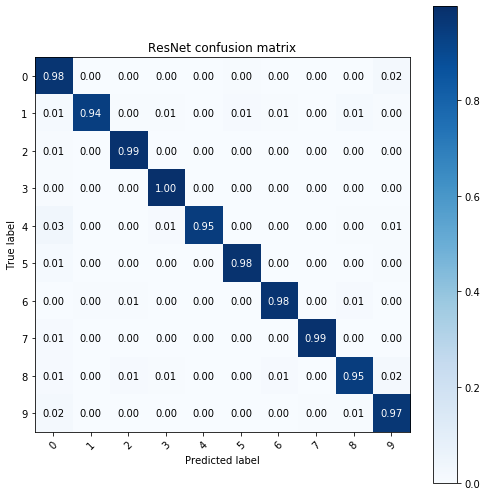

In [ ]:
plt.figure(figsize=(7,7))
plot_confusion_matrix(preds,actual,range(10),normalize=True,title="ResNet confusion matrix",confText=True)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("dd_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("dd_model_weights.h5")
model.save('dd_model.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
#view results on test set
sample_data_dir="/content/test/"
test_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    
test_generator = test_datagen.flow_from_directory(
        sample_data_dir,
        target_size=(224, 224),
        color_mode="rgb",
        shuffle = False,
        class_mode=None,
        batch_size=1)
filenames = test_generator.filenames
nb_samples = len(filenames)
print(nb_samples)
print(filenames)



Found 0 images belonging to 0 classes.
0
[]


In [ ]:
class_desc=['c0: normal driving','c1: texting - right','c2: talking on the phone - right','c3: texting - left',
    'c4: talking on the phone - left','c5: operating the radio','c6: drinking','c7: reaching behind','c8: hair and makeup',
    'c9: talking to passenger']
predict = model.predict_generator(test_generator,steps = nb_samples)
filelist=[os.path.join(sample_data_dir+"New Folder", f) for f in os.listdir(sample_data_dir+"New Folder")]
fig,axes=plt.subplots(len(filelist),1,figsize=(20, 70))
for i in range(0,len(filelist)):
    img=mpimg.imread(filelist[i])
    axes[i].set_xlabel(class_desc[predict[i].argmax(axis=-1)])
    axes[i].imshow(img)
plt.show()

FileNotFoundError: ignored